Pe 0.38910505836575876
Pe 0.3367003367003367


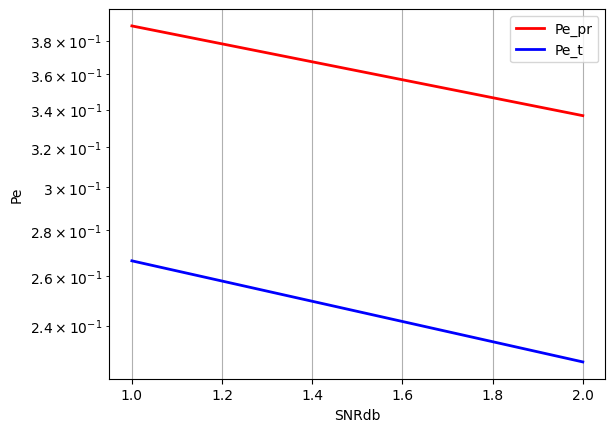

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from numpy.random import default_rng

rng = default_rng()

q = 2
T = 5e-6
f0 = 10e6
dtf = 1 / T

Ns = 50
A = 1
dt = 1 / (Ns * f0)
t = np.arange(0, T, dt)

f = np.zeros(q + 1)
s = np.zeros((q + 1, len(t)))
f1 = np.zeros((q + 1, len(t)))
f2 = np.zeros((q + 1, len(t)))

for i in range(q + 1):
    f[i] = f0 + (i) * dtf
    s[i, :] = A * np.cos(2 * np.pi * f[i] * t)
    f1[i, :] = np.sqrt(2 / T) * np.cos(2 * np.pi * f[i] * t)
    f2[i, :] = np.sqrt(2 / T) * np.sin(2 * np.pi * f[i] * t)

E = np.linalg.norm(s[0, :]) ** 2
Nerrmax = 500
num_tests = 600000
SNRdb = np.arange(1, q + 1, 1)
Pe = np.zeros(len(SNRdb))
Pe_teor = np.zeros(len(SNRdb))

e = 1
m = np.sqrt(e / 2)
sigm = (1 - e) / 2

for ns in range(len(SNRdb)):
    SNR = 10 ** (SNRdb[ns] / 10)
    N0 = E / SNR
    sigma = np.sqrt(N0 / 2)
    Nerr = 0
    Ntest = 0
    Pe_t = 0

    for j in range(1, q + 1):
        Pe_t = Pe_t + comb(q-1,j) * ((-1)**(j + 1)) * (1/(1+j+j*(1-e)*E/N0)) * np.exp(- (j*e*E/N0)/(1+j+j*(1-e)*E/N0))

    last_test = Ntest

    while (Nerr < Nerrmax):
        i = np.floor(rng.random() * q).astype(int)
        x = rng.normal(m, sigm)
        y = rng.normal(m, sigm)
        m_ = np.sqrt(x ** 2 + y ** 2)

        r = m_ * A * np.cos(2 * np.pi * f[i] * t + 2 * np.pi * rng.random()) + sigma * rng.standard_normal(len(t))
        rci = np.zeros(q + 1)
        rsi = np.zeros(q + 1)
        ni = np.zeros(q + 1)

        for j in range(q + 1):
            rci[j] = np.trapz(r * f1[j, :])
            rsi[j] = np.trapz(r * f2[j, :])
            ni[j] = (rci[j] ** 2) + (rsi[j] ** 2)

        max_value, index_max = np.max(ni), np.argmax(ni)
        if index_max != i:
            Nerr = Nerr + 1
            # print(f'{index_max} != {i}')
            # print(f'SNRdb = {SNRdb[ns]} | {Nerr} Nerr | {Ntest} Ntest')

        Ntest = Ntest + 1

        if (Ntest - last_test > num_tests):
            # print(f'> {num_tests} tests')
            # print('Pe ~= 0')
            break

    Pe[ns] = Nerr / Ntest
    Pe_teor[ns] = Pe_t
    print(f'Pe {Pe[ns]}')

plt.figure(1)
plt.semilogy(SNRdb, Pe, 'r', SNRdb, Pe_teor, 'blue', linewidth=2)
plt.xlabel('SNRdb')
plt.ylabel('Pe')
plt.legend(['Pe_pr', 'Pe_t'])
plt.grid(True)
plt.show()
